In [77]:
%config IPCompleter.greedy = True
import pandas as pd
import weka.core.jvm as jvm
from datetime import datetime
from openpyxl import Workbook
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from weka.core.converters import Loader
from weka.associations import Associator
jvm.start()
loader = Loader(classname='weka.core.converters.CSVLoader')

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [78]:
def geraRegras(arq,sup,conf):
    data = loader.load_file(arq)

    #Gera as regras e alimenta rules.
    associator = Associator(classname='weka.associations.Apriori', options=["-N", "1000000", "-C", sup, "-M", conf])
    associator.build_associations(data)
    rules = associator.association_rules()

    #Chama a função de transformação
    df_regras = rules_to_dframe(rules)

    #Retira do DF as colunas leverage e conviction
    df_regras.drop('leverage', axis=1, inplace=True)
    df_regras.drop('conviction', axis=1, inplace=True)

    #Separa as regras que contem mais de 1 antecedente.
    df_regras['antecedente'].apply(lambda x: x.split(',')[0])
    
    return df_regras

In [79]:
#Função para transformar o objeto rules em um dataframe
def rules_to_dframe(rules):
    ''' Convert a set of generated rules and their metrics into a DataFrame. '''

    arules = []

    for rule in rules:

        arule = {
            'antecedente': ','.join(['{}'.format(x) for x in rule.premise]),
            'consequente': ','.join(['{}'.format(x) for x in rule.consequence]),
            'suporte': rule.total_support/rule.total_transactions
        }
        index_names = [x.lower() for x in rule.metric_names]
        metrics = dict(zip(index_names, rule.metric_values))
        arule.update(metrics)
        arules.append(arule)

    return pd.DataFrame.from_dict(arules)

In [80]:
def atualizaPlanGeral(antecedentes,consequente,titulo,wb):
    rotulos =[]
    for items in antecedentes:
        rotulos.append(items.split('=')[1])
    
    #Filtra o df_regras (que contém todas as regras), de acordo com a quantidade de antecedentes repassados.
    #É possível dinamizar esse passo??
    if len(antecedentes) == 2:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1])]
    elif len(antecedentes) == 3:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2])]
    elif len(antecedentes) == 4:    
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2]) | (df_regras['antecedente'] == antecedentes[3])]
    else:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0])]

    #Depois de filtrar os antecedentes, agora é filtrado pelo consequente da regra
    dfFiltro = dfFiltro.loc[(dfFiltro['consequente'] == consequente)]

    #Por fim, filtra somente as regras com 1 item no antecedente da regra
    dfFiltro['antecedente'] = dfFiltro['antecedente'].apply(lambda x: x.split('=')[1])

    #Reorganiza o index, baseado no rótulo originais, afim de deixar organizado o DF para atualização da planilha e geração do gráfico
    dfFiltro = dfFiltro.set_index('antecedente').reindex(rotulos).reset_index()
    #Seleciona a aba correspondente à regra na planilha do Excel
   
    planilha = wb[titulo]
    #Preenche a célula [1,1] com o título correspondente à regra
    planilha['A1'] = titulo
    planilha['B1'] = 'Suporte'
    planilha['C1'] = 'Confiança'
    planilha['D1'] = 'Lift'

    i = 1
    #Percorre a lista que contem os rótulos das regras
    for items in rotulos:
        #Preenche a linha 1 com os rótulos das regras
        planilha.cell(row=i+1, column=1).value = items
        i = i+1
    
    #Itera sob a quantidade de rótulos para preencher os valores de suporte, confiança e Lift
    for item in range(len(rotulos)):
        #Preenche a planilha com os valores do DF
        planilha.cell(row=item+2, column=2).value = dfFiltro.loc[item, 'suporte']
        planilha.cell(row=item+2, column=3).value = dfFiltro.loc[item, 'confidence']
        planilha.cell(row=item+2, column=4).value = dfFiltro.loc[item, 'lift']

In [37]:
def atualizaPlanilhaPart(antecedentes,consequente,titulo,var,wb):
    rotulos =[]
    for items in antecedentes:
        rotulos.append(items.split('=')[1])
    
    #Filtra o df_regras (que contém todas as regras), de acordo com a quantidade de antecedentes repassados.
    #É possível dinamizar esse passo??
    if len(antecedentes) == 2:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1])]
    elif len(antecedentes) == 3:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2])]
    elif len(antecedentes) == 4:    
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2]) | (df_regras['antecedente'] == antecedentes[3])]
    else:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0])]

    #Depois de filtrar os antecedentes, agora é filtrado pelo consequente da regra
    dfFiltro = dfFiltro.loc[(dfFiltro['consequente'] == consequente)]

    #Por fim, filtra somente as regras com 1 item no antecedente da regra
    dfFiltro['antecedente'] = dfFiltro['antecedente'].apply(lambda x: x.split('=')[1])

    #Reorganiza o index, baseado no rótulo originais, afim de deixar organizado o DF para atualização da planilha e geração do gráfico
    dfFiltro = dfFiltro.set_index('antecedente').reindex(rotulos).reset_index()
    #Seleciona a aba correspondente à regra na planilha do Excel
    planilha = wb[titulo]
    #Preenche a célula [1,1] com o título correspondente à regra
    planilha['A1'] = titulo

    i = 1
    #Percorre a lista que contem os rótulos das regras
    for items in rotulos:
        #Preenche a linha 1 com os rótulos das regras
        planilha.cell(row=1, column=i+1).value = items
        i = i+1
    
    #Preenche a coluna A com a referência do nome da partição
    planilha.cell(row=indice+1, column=1).value = var
    #Itera sob a quantidade de rótulos para preencher os valores de Lift
    for item in range(len(rotulos)):
        #Preenche a planilha com os valores do DF
        planilha.cell(row=indice+1, column=item+2).value = dfFiltro.loc[item, 'lift']

In [81]:
def criaPlanilha(nome,sheets):
    #Cria estrutura do arquivo Excel
    wb = Workbook()
    #Para cada item passado como parâmetro, cria uma Aba na planilha
    for item in sheets:
        planilha = wb.create_sheet(item)
    #Remove a primeira planilha, que não faz parte da lista e que não descobri como fazer para não criar ela.
    wb.remove(wb['Sheet'])
    wb.save(nome+".xlsx")
    return wb

In [82]:
df_regras = geraRegras('angularLimpo2_semData.csv','0.004','0.009')

arquivo_excel = criaPlanilha('AngularJS_PadroesGerais',['FilesChangedMerged','FilesChangedClosed','CommitsMerged','CommitsClosed','MainTeamMerged','MainTeamClosed','LifetimeMerged','LifetimeClosed','CommentsMerged','CommentsClosed','FirstPullMerged','FirstPullClosed','PrevContribMerged','PrevContribClosed'])

#Filtra somente as regras de FilesChanged - Merged
atualizaPlanGeral(['filesChangedD=1 file','filesChangedD=some files','filesChangedD=many files'],'merged=True','FilesChangedMerged',arquivo_excel)
#----------------------------------------------------------------------------------    
#Filtra somente as regras de FilesChanged - Closed
atualizaPlanGeral(['filesChangedD=1 file','filesChangedD=some files','filesChangedD=many files'],'merged=False','FilesChangedClosed',arquivo_excel)
#----------------------------------------------------------------------------------
atualizaPlanGeral(['commitsD=1 commit','commitsD=some commits','commitsD=many commits'],'merged=True','CommitsMerged',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de Commits - Closed
atualizaPlanGeral(['commitsD=1 commit','commitsD=some commits','commitsD=many commits'],'merged=False','CommitsClosed',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de MainTeamMember - Merged
atualizaPlanGeral(['main_team_member=True','main_team_member=False'],'merged=True','MainTeamMerged',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de MainTeamMember - Closed
atualizaPlanGeral(['main_team_member=True','main_team_member=False'],'merged=False','MainTeamClosed',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de Lifetime - Merged
atualizaPlanGeral(['lifetime=very slow','lifetime=slow','lifetime=fast','lifetime=very fast'],'merged=True','LifetimeMerged',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de Lifetime - Closed
atualizaPlanGeral(['lifetime=very slow','lifetime=slow','lifetime=fast','lifetime=very fast'],'merged=False','LifetimeClosed',arquivo_excel)
#----------------------------------------------------------------------------------    
#Filtra somente as regras de Comments - Merged
atualizaPlanGeral(['commentsD=has comments','commentsD=no comments'],'merged=True','CommentsMerged',arquivo_excel)
#----------------------------------------------------------------------------------    
#Filtra somente as regras de Comments - Closed
atualizaPlanGeral(['commentsD=has comments','commentsD=no comments'],'merged=False','CommentsClosed',arquivo_excel)
#----------------------------------------------------------------------------------    
#Filtra somente as regras de FirstPull - Merged
atualizaPlanGeral(['first_pull=True','first_pull=False'],'merged=True','FirstPullMerged',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de FirstPull - Closed
atualizaPlanGeral(['first_pull=True','first_pull=False'],'merged=False','FirstPullClosed',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de prevContribD - Merged
atualizaPlanGeral(['prevContribD=no contributions','prevContribD=some contributions','prevContribD=many contributions'],'merged=True','PrevContribMerged',arquivo_excel)
#----------------------------------------------------------------------------------
#Filtra somente as regras de prevContribD - Closed
atualizaPlanGeral(['prevContribD=no contributions','prevContribD=some contributions','prevContribD=many contributions'],'merged=False','PrevContribClosed',arquivo_excel)
#----------------------------------------------------------------------------------
arquivo_excel.save("AngularJS_PadroesGerais.xlsx")

In [83]:
df_angular = pd.read_csv('angularLimpo2.csv')
df_angular['created_at'] = pd.to_datetime(df_angular['created_at'])
ultimaData = df_angular['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S').max()
intervalo = 8
janela = 6
indice = 1
comeca = df_angular['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S').min()
arquivo_excel = criaPlanilha('AngularJS_PadroesParticoes',['FilesChangedMerged','FilesChangedClosed','CommitsMerged','CommitsClosed','MainTeamMerged','MainTeamClosed','LifetimeMerged','LifetimeClosed','CommentsMerged','CommentsClosed','FirstPullMerged','FirstPullClosed','PrevContribMerged','PrevContribClosed'])

while True:
    termina = str(datetime.fromordinal(datetime.strptime(comeca, '%Y-%m-%d %H:%M:%S').date().toordinal()+(intervalo * 30)))
    variavel = 'part_' + str(indice)
    vars()[variavel] = df_angular.query("created_at >= '"+comeca+"' and created_at <= '"+termina+"'")
    
    #tirar isso depois, estou tirando a data do arquivo CSV
    vars()[variavel] = vars()[variavel].drop(columns=['created_at'])
    
    vars()[variavel].to_csv(variavel+".csv", index=False)
    
    if (termina > ultimaData):
        break
    #invoca a função que gera as regras a partir do CSV de cada partição, com SUP e CONF
    df_regras = geraRegras(variavel+".csv",'0.1','0.1')
    
    #Filtra somente as regras de FilesChanged - Merged
    atualizaPlanilhaPart(['filesChangedD=1 file','filesChangedD=some files','filesChangedD=many files'],'merged=True','FilesChangedMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------        
    #Filtra somente as regras de FilesChanged - Closed
    atualizaPlanilhaPart(['filesChangedD=1 file','filesChangedD=some files','filesChangedD=many files'],'merged=False','FilesChangedClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de Commits - Merged
    atualizaPlanilhaPart(['commitsD=1 commit','commitsD=some commits','commitsD=many commits'],'merged=True','CommitsMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de Commits - Closed
    atualizaPlanilhaPart(['commitsD=1 commit','commitsD=some commits','commitsD=many commits'],'merged=False','CommitsClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de MainTeamMember - Merged
    atualizaPlanilhaPart(['main_team_member=True','main_team_member=False'],'merged=True','MainTeamMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de MainTeamMember - Closed
    atualizaPlanilhaPart(['main_team_member=True','main_team_member=False'],'merged=False','MainTeamClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de Lifetime - Merged
    atualizaPlanilhaPart(['lifetime=very slow','lifetime=slow','lifetime=fast','lifetime=very fast'],'merged=True','LifetimeMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de Lifetime - Closed
    atualizaPlanilhaPart(['lifetime=very slow','lifetime=slow','lifetime=fast','lifetime=very fast'],'merged=False','LifetimeClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------    
    #Filtra somente as regras de Comments - Merged
    atualizaPlanilhaPart(['commentsD=has comments','commentsD=no comments'],'merged=True','CommentsMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------    
    #Filtra somente as regras de Comments - Closed
    atualizaPlanilhaPart(['commentsD=has comments','commentsD=no comments'],'merged=False','CommentsClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------    
    #Filtra somente as regras de FirstPull - Merged
    atualizaPlanilhaPart(['first_pull=True','first_pull=False'],'merged=True','FirstPullMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de FirstPull - Closed
    atualizaPlanilhaPart(['first_pull=True','first_pull=False'],'merged=False','FirstPullClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de prevContribD - Merged
    atualizaPlanilhaPart(['prevContribD=no contributions','prevContribD=some contributions','prevContribD=many contributions'],'merged=True','PrevContribMerged',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------
    #Filtra somente as regras de prevContribD - Closed
    atualizaPlanilhaPart(['prevContribD=no contributions','prevContribD=some contributions','prevContribD=many contributions'],'merged=False','PrevContribClosed',variavel,arquivo_excel)
    #----------------------------------------------------------------------------------     
    #Salva o arquivo com os padrões das regras de cada partição.
    arquivo_excel.save("AngularJS_PadroesParticoes.xlsx")
    #Incrementa a variavel que controla em que data começará a nova partição
    comeca = str(datetime.fromordinal(datetime.strptime(comeca, '%Y-%m-%d %H:%M:%S').date().toordinal()+(janela * 30)))
    #Incrementa o indice que controlará o nome da partição
    indice = indice + 1

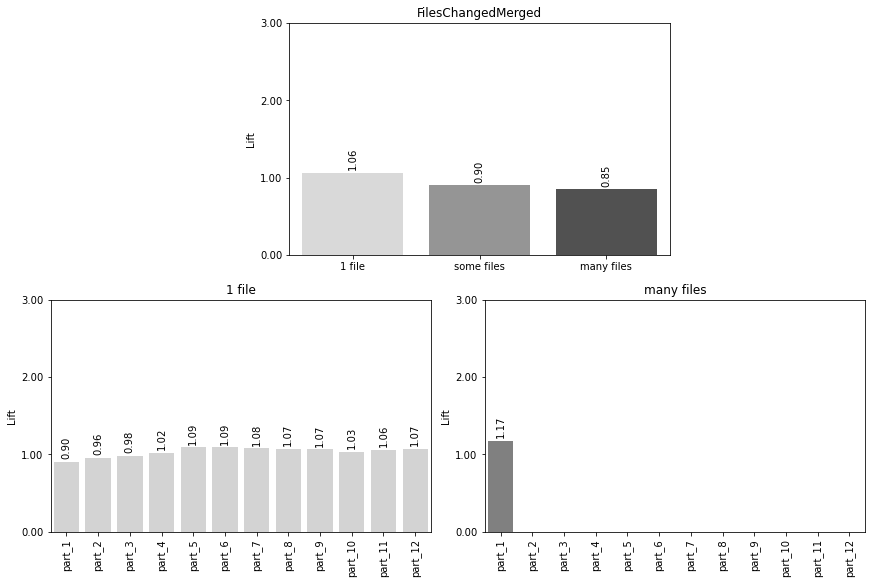

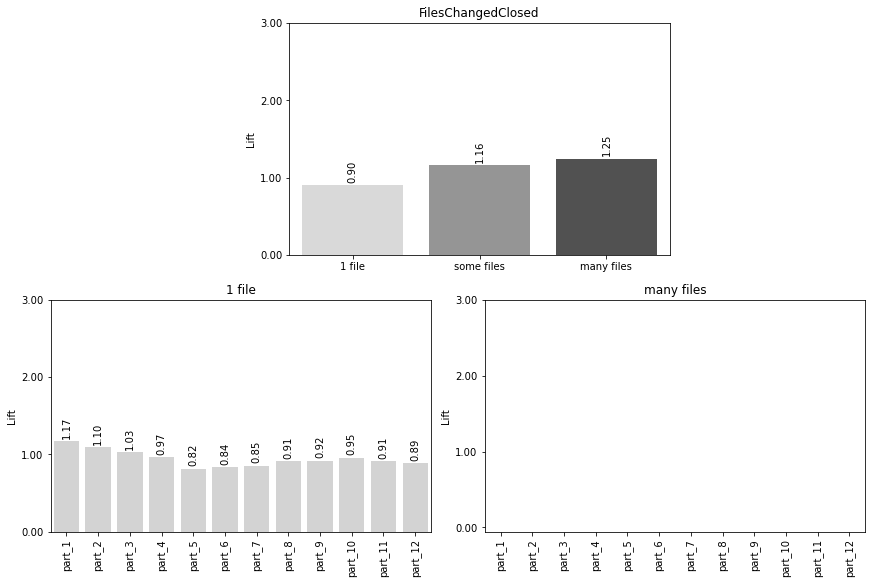

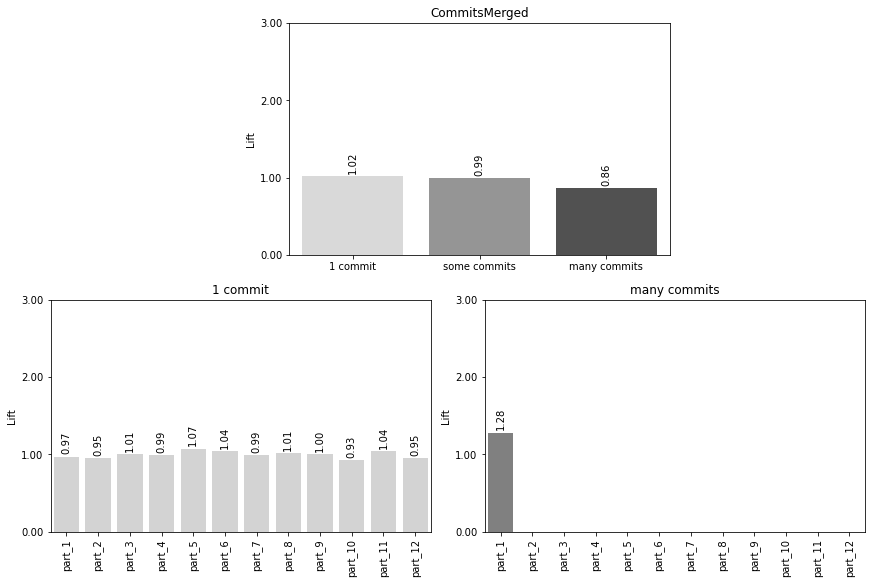

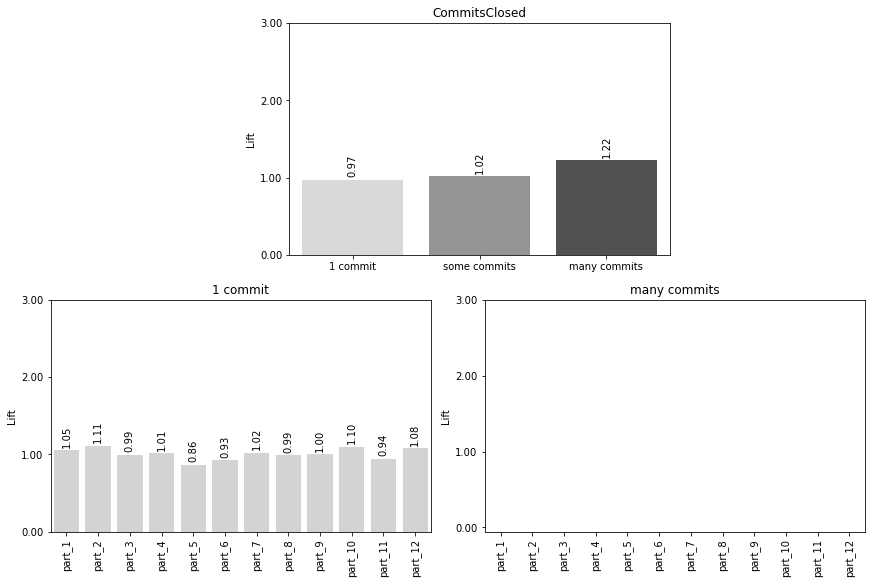

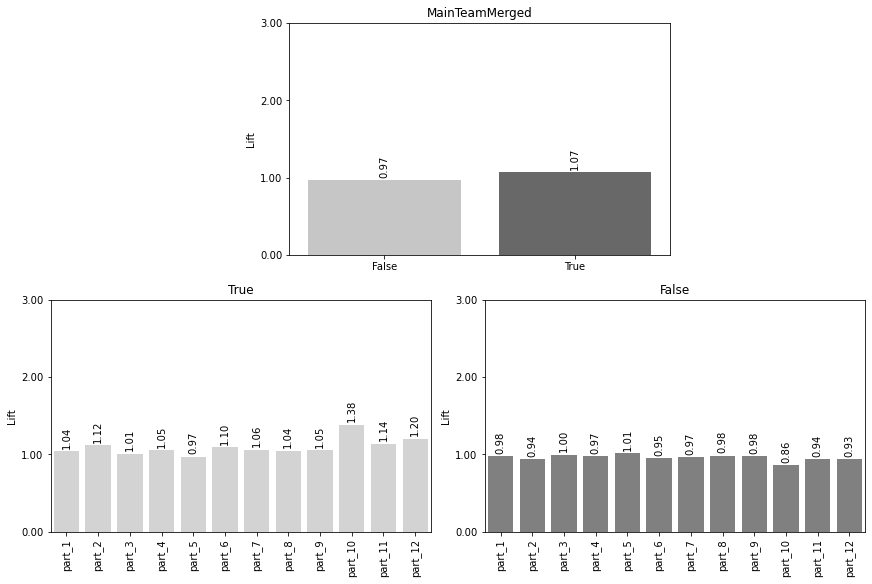

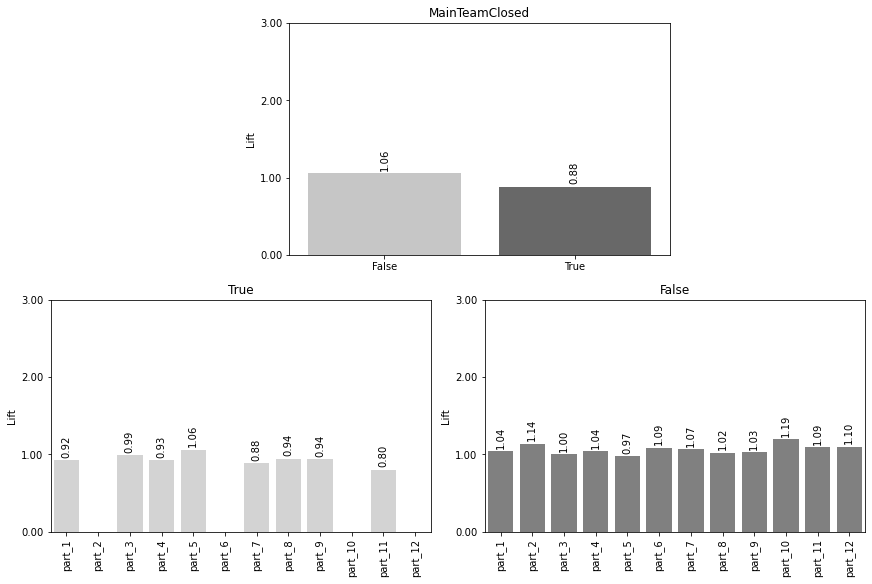

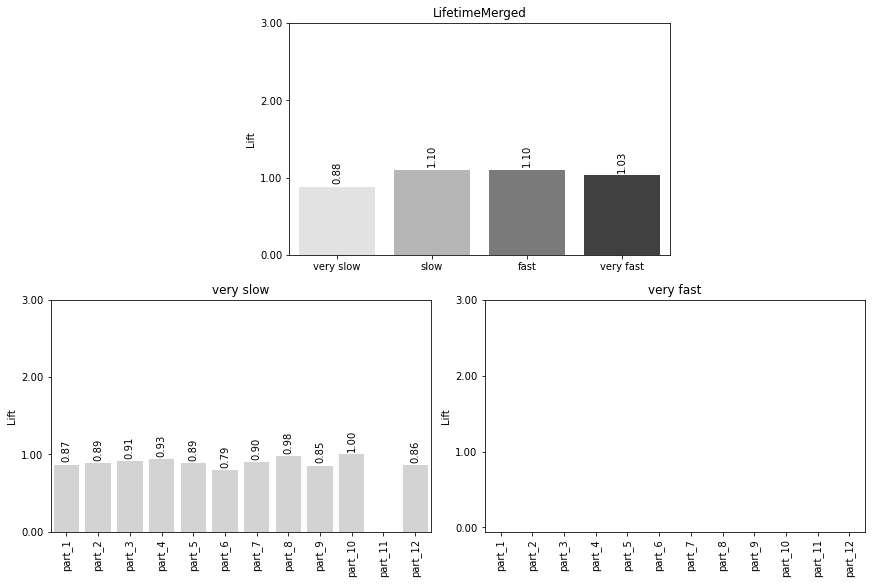

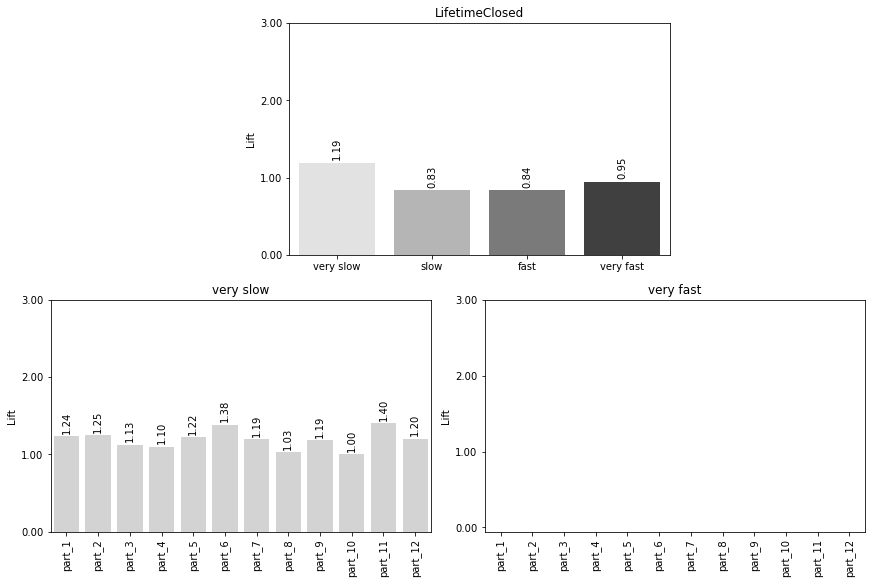

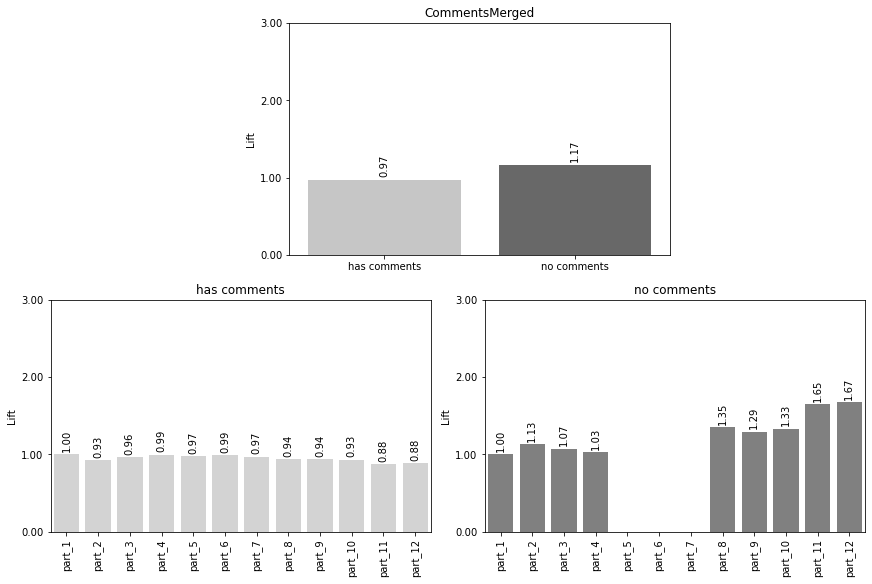

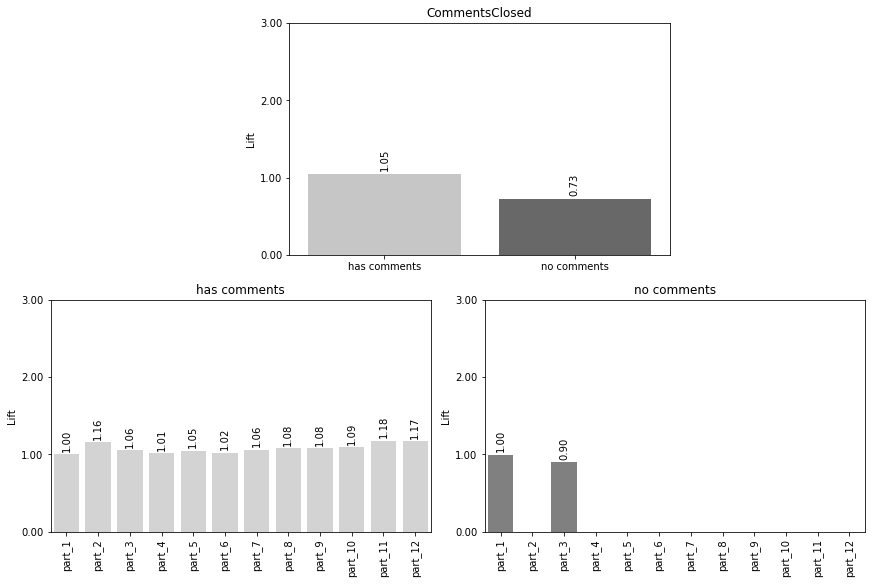

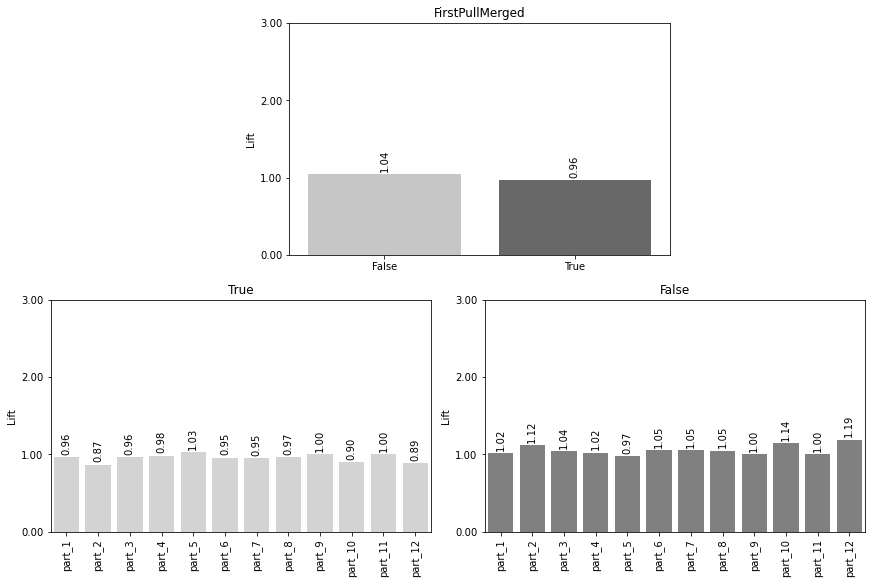

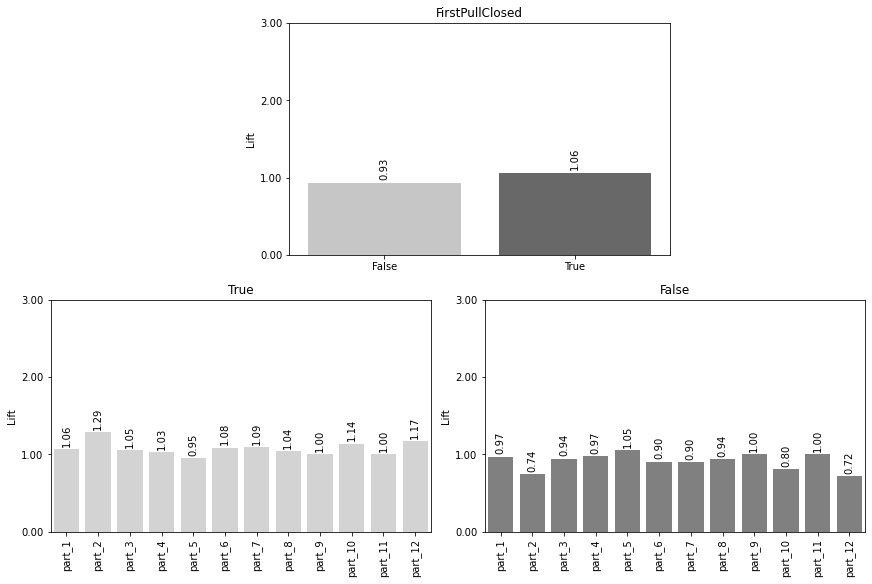

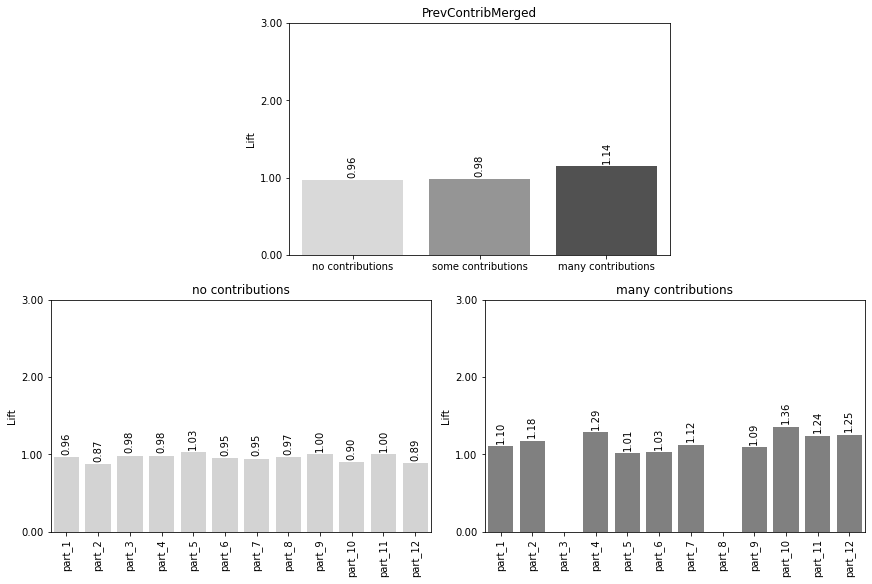

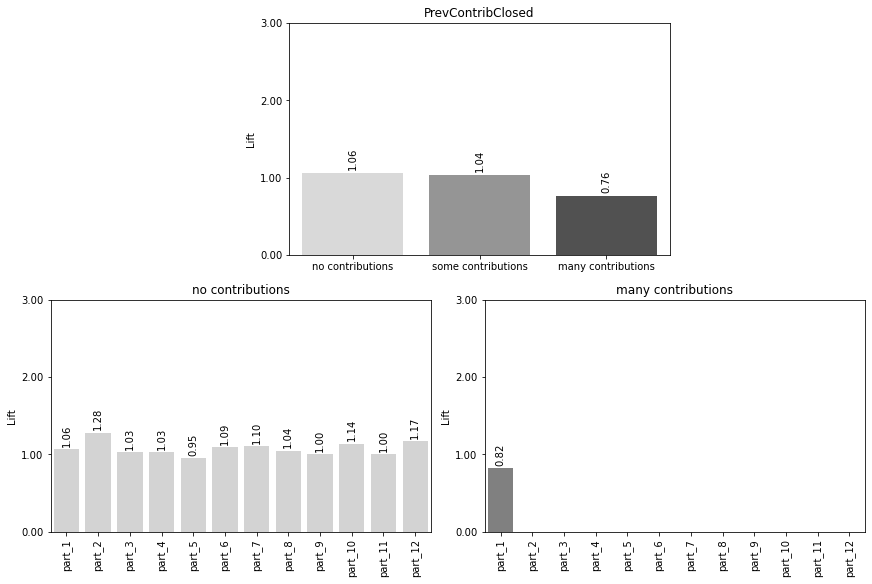

In [175]:
geraGrafico('AngularJS_PadroesGerais.xlsx','AngularJS_PadroesParticoes.xlsx',['FilesChangedMerged','FilesChangedClosed','CommitsMerged','CommitsClosed','MainTeamMerged','MainTeamClosed','LifetimeMerged','LifetimeClosed','CommentsMerged','CommentsClosed','FirstPullMerged','FirstPullClosed','PrevContribMerged','PrevContribClosed'])

In [174]:
def geraGrafico(excelGeral,excelPart,regras):
    xlsGeral = pd.ExcelFile(excelGeral)
    xlsParticoes = pd.ExcelFile(excelPart)
    
    #Para cada regra na lista, geral o conjunto de 3 figuras para análise
    for item in regras:
        geral = pd.read_excel(xlsGeral, item)
        part = pd.read_excel(xlsParticoes, item)
        
        fig = plt.figure(constrained_layout=True, figsize=(12, 8))
        gs = fig.add_gridspec(2, 4)
        
        ax1 = fig.add_subplot(gs[0, 1:3])
        splot=sns.barplot(ax=ax1, data=geral, x=item, y="Lift", palette='Greys')
        ax1.set_title(item)
        ax1.set(xlabel='')
        #Código para rotular as barras
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        #Formata os tickers do eixo Y para mostrar a casa decimal .00
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
             
        ax2 = fig.add_subplot(gs[1, :2])
        splot=sns.barplot(x=item, y=part.iloc[:,1], data=part, color='LightGrey')
        ax2.set_title(part.columns[1])
        ax2.set(ylabel='Lift', xlabel='')
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
           
        ax3 = fig.add_subplot(gs[1, 2:])
        splot=sns.barplot(ax=ax3, data=part, x=item, y=part.iloc[:,-1], color='grey')
        ax3.set_title(part.columns[-1])
        ax3.set(ylabel='Lift', xlabel='')
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
               
        #Formata os tickers do eixo Y para contagem 0, 1, 2, 3 para o primeiro gráfico, axes[0].
        plt.sca(ax1)
        plt.yticks([0, 1, 2, 3])
        plt.sca(ax2)
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)
        plt.sca(ax3)
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)
        plt.savefig(item+'.eps', format='eps')
        plt.savefig(item+'.png')

In [ ]:
def geraGraficoII(excelGeral,excelPart,regras):
    xlsGeral = pd.ExcelFile(excelGeral)
    xlsParticoes = pd.ExcelFile(excelPart)
    #Para cada regra na lista, geral o conjunto de 3 figuras para análise
    for item in regras:
        geral = pd.read_excel(xlsGeral, item)
        part = pd.read_excel(xlsParticoes, item)
                
        #Cria subplots chamados axes que serão referenciados como arrays
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        #fig.suptitle('Análise AngularJS')
        #Define o primeiro subplot, axes[0,0]
        splot=sns.barplot(ax=axes[0,0], data=geral, x=item, y="Lift", palette='Greys')
        axes[0,0].set_title(item)
        #Código para rotular as barras
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        #Formata os tickers do eixo Y para mostrar a casa decimal .00
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        splot=sns.barplot(ax=axes[1,0], data=part, x=item, y=part.iloc[:,1], color='LightGrey')
        #axes[1,0].set_title(item)
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        splot=sns.barplot(ax=axes[1,1], data=part, x=item, y=part.iloc[:,-1], color='grey')
        #axes[1,1].set_title(item)
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


        #Formata os tickers do eixo Y para contagem 0, 1, 2, 3 para o primeiro gráfico, axes[0].
        plt.sca(axes[0,0])
        plt.yticks([0, 1, 2, 3])
        plt.sca(axes[0,1])
        plt.yticks([0, 1, 2, 3])
        plt.sca(axes[1,0])
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)
        plt.sca(axes[1,1])
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)

In [ ]:
def geraGraficoIII(excelGeral,excelPart,regras):
    xlsGeral = pd.ExcelFile(excelGeral)
    xlsParticoes = pd.ExcelFile(excelPart)
    for item in regras:
        geral = pd.read_excel(xlsGeral, item)
        part = pd.read_excel(xlsParticoes, item)
        #rows = part.rows
        #Cria subplots chamados axes que serão referenciados como arrays
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        #fig.suptitle('Análise AngularJS')
        #Define o primeiro subplot, axes[0,0]
        splot=sns.barplot(ax=axes[0,0], data=geral, x=item, y="Lift", palette='Greys')
        axes[0,0].set_title(item)
        #Código para rotular as barras
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        #Formata os tickers do eixo Y para mostrar a casa decimal .00
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        splot=sns.barplot(ax=axes[1,0], data=part, x=item, y="1 file", color='LightGrey')
        #axes[1,0].set_title(item)
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        splot=sns.barplot(ax=axes[1,1], data=part, x=item, y="many files", color='grey')
        #axes[1,1].set_title(item)
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 14), rotation=90, 
                           textcoords = 'offset points', fontsize=10)
        splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


        #Formata os tickers do eixo Y para contagem 0, 1, 2, 3 para o primeiro gráfico, axes[0].
        plt.sca(axes[0,0])
        plt.yticks([0, 1, 2, 3])
        plt.sca(axes[0,1])
        plt.yticks([0, 1, 2, 3])
        plt.sca(axes[1,0])
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)
        plt.sca(axes[1,1])
        plt.yticks([0, 1, 2, 3])
        plt.xticks(rotation=90)

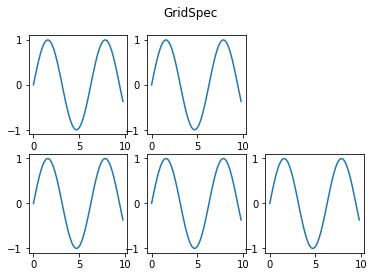

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=False)
x = np.arange(0, 10, 0.2)
y = np.sin(x)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax1.plot(x, y)
ax2.plot(x, y)
ax3.plot(x, y)
ax4.plot(x, y)
ax5.plot(x, y)
fig.suptitle("GridSpec")

plt.show()

Text(0, 0.5, 'Lift')

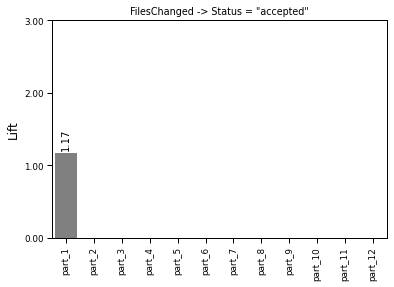

In [54]:
xls = pd.ExcelFile('AngularJS_PadroesParticoes.xlsx')
dfFCM = pd.read_excel(xls, 'FilesChangedMerged')
#dfFCC = pd.read_excel(xls, 'FilesChangedClosed')
plt.figure(figsize=(6, 4))
splot=sns.barplot(data=dfFCM, x='FilesChanged-Merged', y="many files", color='grey')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
plt.title('FilesChanged -> Status = "accepted"')
plt.xlabel('');
plt.yticks([0, 1, 2, 3]) # mudar escala do eixo X
plt.xticks(rotation=90)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.ylabel("Lift", size=12)
#plt.savefig("teste.eps", format='eps')
#plt.savefig("teste.png")

In [ ]:
#Gera descrição dos meses contidos na base
df_angular['created_at'].groupby([df_angular.created_at.dt.year, df_angular.created_at.dt.month]).agg('count').describe()

#Gera gráfico com agrupamento Ano/mês e quantidade de PR's em cada mês.
df_angular['created_at'].groupby([df_angular.created_at.dt.year, df_angular.created_at.dt.month]).agg('count').plot(kind='bar')
plt.rcParams['figure.figsize'] = (20,8)
plt.xlabel("Quantidade de PR's")
plt.ylabel("Agregação Ano/Mês")
plt.title("Quantidade de PR's por Mês no pojeto AngularJS")
plt.savefig('QtdPR_Mes_Angular.png')

In [ ]:
#Exemplo 3: Desenhando um gráfico de barras horizontal:

def plota_barra():
   sns.set(style="whitegrid", color_codes=True)
   #sns.set_color_codes("true")
   g = sns.barplot(data=filtro_files, x='antecedente', y="lift", ci="none", color="grey")
   g.axes.set_title('Gráfico', fontsize=18,color="black",alpha=2)
  
   g.set_ylabel("lift", size = 12,color="black")
   sns.despine(left=True, bottom=True)
   plt.show()

In [ ]:
plota_barra()

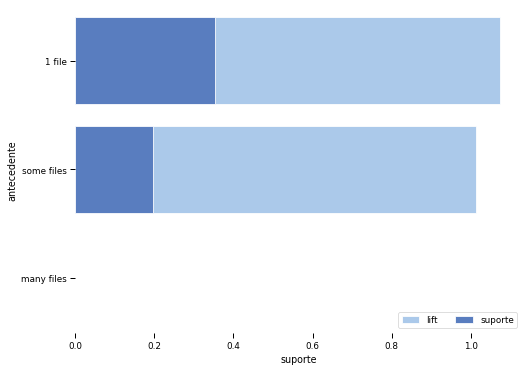

In [36]:
sns.set_context('paper')

f, ax = plt.subplots(figsize = (8,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'lift', y = 'antecedente', data = filtro_filesM, label = 'lift', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'suporte', y = 'antecedente', data = filtro_filesM, label = 'suporte', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()

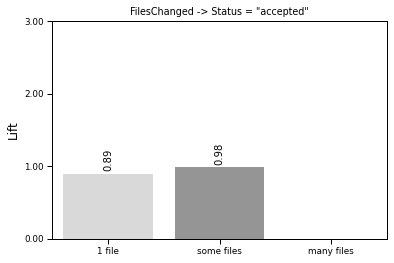

In [37]:
plt.figure(figsize=(6, 4))
splot=sns.barplot(data=filtro_filesC, x='antecedente', y="lift", palette='Greys')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
plt.title('FilesChanged -> Status = "accepted"')
plt.xlabel('');
plt.yticks([0, 1, 2, 3]) # mudar escala do eixo X
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.ylabel("Lift", size=12)
plt.savefig("teste.eps", format='eps')
plt.savefig("teste.png")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle('Análise AngularJS')

#plt.setp(axes, yticks=[0, 1, 2, 3])
splot=sns.barplot(ax=axes[0], data=filtro_filesC, x='antecedente', y="lift", palette='Greys')
axes[0].set_title('FilesChanged->Closed')
#axes[0].xlabel('')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)

splot=sns.barplot(ax=axes[1], data=filtro_filesM, x='antecedente', y="lift", palette='Greys')
axes[1].set_title('FilesChanged->Merged')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
plt.sca(axes[0])
plt.yticks([0, 1, 2, 3], color='red')
#plt.yticks([0, 1, 2, 3]) # mudar escala do eixo X
#splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

In [ ]:
plt.savefig("filesChangedClosed.eps", format='eps')
plt.savefig("filesChangedClosed.png")

In [ ]:
#Cria subplots chamados axes que serão referenciados como arrays
fig, axes = plt.subplots(7, 2, figsize=(20, 38))
fig.suptitle('Análise AngularJS')
#Define o primeiro subplot, axes[0,0]
splot=sns.barplot(ax=axes[0,0], data=filtro_filesM, x='antecedente', y="lift", palette='Greys')
axes[0,0].set_title('FilesChanged->Merged')
#Código para rotular as barras
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
#Formata os tickers do eixo Y para mostrar a casa decimal .00
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[0,1], data=filtro_filesC, x='antecedente', y="lift", palette='Greys')
axes[0,1].set_title('FilesChanged->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[1,0], data=filtro_commitsM, x='antecedente', y="lift", palette='Greys')
axes[1,0].set_title('Commits->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[1,1], data=filtro_commitsC, x='antecedente', y="lift", palette='Greys')
axes[1,1].set_title('Commits->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[2,0], data=filtro_mainTeamM, x='antecedente', y="lift", palette='Greys')
axes[2,0].set_title('MainTeam->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[2,1], data=filtro_mainTeamC, x='antecedente', y="lift", palette='Greys')
axes[2,1].set_title('MainTeam->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[3,0], data=filtro_lifetimeM, x='antecedente', y="lift", palette='Greys')
axes[3,0].set_title('Lifetime->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[3,1], data=filtro_lifetimeC, x='antecedente', y="lift", palette='Greys')
axes[3,1].set_title('Lifetime->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[4,0], data=filtro_commentsM, x='antecedente', y="lift", palette='Greys')
axes[4,0].set_title('Comments->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[4,1], data=filtro_commentsC, x='antecedente', y="lift", palette='Greys')
axes[4,1].set_title('Comments->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[5,0], data=filtro_firstPullM, x='antecedente', y="lift", palette='Greys')
axes[5,0].set_title('FirstPull->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[5,1], data=filtro_firstPullC, x='antecedente', y="lift", palette='Greys')
axes[5,1].set_title('FirstPull->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


splot=sns.barplot(ax=axes[6,0], data=filtro_prevContribM, x='antecedente', y="lift", palette='Greys')
axes[6,0].set_title('PrevContributions->Merged')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

splot=sns.barplot(ax=axes[6,1], data=filtro_prevContribC, x='antecedente', y="lift", palette='Greys')
axes[6,1].set_title('PrevContributions->Closed')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), rotation=90, 
                   textcoords = 'offset points', fontsize=10)
splot.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

#Formata os tickers do eixo Y para contagem 0, 1, 2, 3 para o primeiro gráfico, axes[0].
plt.sca(axes[0,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[0,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[1,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[1,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[2,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[2,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[3,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[3,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[4,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[4,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[5,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[5,1])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[6,0])
plt.yticks([0, 1, 2, 3])
plt.sca(axes[6,1])
plt.yticks([0, 1, 2, 3])

In [ ]:
def atualizaPlanGeral(antecedentes,consequente,titulo,wb):
    rotulos =[]
    for items in antecedentes:
        rotulos.append(items.split('=')[1])
    
    #Filtra o df_regras (que contém todas as regras), de acordo com a quantidade de antecedentes repassados.
    #É possível dinamizar esse passo??
    if len(antecedentes) == 2:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1])]
    elif len(antecedentes) == 3:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2])]
    elif len(antecedentes) == 4:    
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0]) | (df_regras['antecedente'] == antecedentes[1]) | (df_regras['antecedente'] == antecedentes[2]) | (df_regras['antecedente'] == antecedentes[3])]
    else:
        dfFiltro = df_regras.loc[(df_regras['antecedente'] == antecedentes[0])]

    #Depois de filtrar os antecedentes, agora é filtrado pelo consequente da regra
    dfFiltro = dfFiltro.loc[(dfFiltro['consequente'] == consequente)]

    #Por fim, filtra somente as regras com 1 item no antecedente da regra
    dfFiltro['antecedente'] = dfFiltro['antecedente'].apply(lambda x: x.split('=')[1])

    #Reorganiza o index, baseado no rótulo originais, afim de deixar organizado o DF para atualização da planilha e geração do gráfico
    dfFiltro = dfFiltro.set_index('antecedente').reindex(rotulos).reset_index()
    #Seleciona a aba correspondente à regra na planilha do Excel
   
    planilha = wb[titulo]
    #Preenche a célula [1,1] com o título correspondente à regra
    planilha['A1'] = titulo
    planilha['A2'] = 'Suporte'
    planilha['A3'] = 'Confiança'
    planilha['A4'] = 'Lift'

    i = 1
    #Percorre a lista que contem os rótulos das regras
    for items in rotulos:
        #Preenche a linha 1 com os rótulos das regras
        planilha.cell(row=1, column=i+1).value = items
        i = i+1
    
    #Itera sob a quantidade de rótulos para preencher os valores de suporte, confiança e Lift
    for item in range(len(rotulos)):
        #Preenche a planilha com os valores do DF
        planilha.cell(row=2, column=item+2).value = dfFiltro.loc[item, 'suporte']
        planilha.cell(row=3, column=item+2).value = dfFiltro.loc[item, 'confidence']
        planilha.cell(row=4, column=item+2).value = dfFiltro.loc[item, 'lift']